In [1]:
#project_name = "."
project_name = "jfreechart"
#project_name = "argouml"
#project_name = "weka"

In [2]:
import torch
import random

def load_pyg_dataset(file_path):
    return torch.load(file_path)

output_file_path = "output/" + project_name + "/pyg_dataset_for_problematic_class.pt"
dataset = load_pyg_dataset(output_file_path)

def add_train_mask_to_pyg_data(data, train_ratio=0.8):
    num_nodes = data.num_nodes
    num_train_nodes = int(train_ratio * num_nodes)

    # Generate a list of True and False values with the specified ratio
    mask_values = [True] * num_train_nodes + [False] * (num_nodes - num_train_nodes)

    # Randomly shuffle the mask values
    random.shuffle(mask_values)

    # Convert the mask_values list to a boolean tensor and assign it to the Data object
    data.train_mask = torch.tensor(mask_values, dtype=torch.bool)

def add_test_mask_to_pyg_data(data):
    # If the train_mask is not set, raise an exception
    if not hasattr(data, 'train_mask'):
        raise ValueError("Please add a train_mask to the Data object first.")
    
    # Create a test mask as the complement of the train mask
    data.test_mask = ~data.train_mask


add_train_mask_to_pyg_data(dataset, train_ratio=0.7)
add_test_mask_to_pyg_data(dataset)

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: Data(x=[589, 18], edge_index=[2, 6357], y=[589], num_classes=2, train_mask=[589], test_mask=[589]):
Number of graphs: 6
Number of features: 18
Number of classes: 2

Data(x=[589, 18], edge_index=[2, 6357], y=[589], num_classes=2, train_mask=[589], test_mask=[589])
Number of nodes: 589
Number of edges: 6357
Average node degree: 10.79
Number of training nodes: 412
Training node label rate: 0.70
Has isolated nodes: False
Has self-loops: True
Is undirected: False


In [3]:
import torch
from torch.nn import Linear
import torch.nn.functional as F


class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        #torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=18, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=2, bias=True)
)


In [4]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

for epoch in range(1, 1001):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 6.9125
Epoch: 002, Loss: 6.1104
Epoch: 003, Loss: 5.9710
Epoch: 004, Loss: 5.2840
Epoch: 005, Loss: 6.3078
Epoch: 006, Loss: 3.3036
Epoch: 007, Loss: 2.9094
Epoch: 008, Loss: 3.1526
Epoch: 009, Loss: 2.9516
Epoch: 010, Loss: 2.2074
Epoch: 011, Loss: 1.5402
Epoch: 012, Loss: 1.5618
Epoch: 013, Loss: 1.5585
Epoch: 014, Loss: 1.2105
Epoch: 015, Loss: 0.9107
Epoch: 016, Loss: 0.7759
Epoch: 017, Loss: 0.7728
Epoch: 018, Loss: 0.6452
Epoch: 019, Loss: 0.5530
Epoch: 020, Loss: 0.5267
Epoch: 021, Loss: 0.5348
Epoch: 022, Loss: 0.5426
Epoch: 023, Loss: 0.5164
Epoch: 024, Loss: 0.5021
Epoch: 025, Loss: 0.4977
Epoch: 026, Loss: 0.4726
Epoch: 027, Loss: 0.4561
Epoch: 028, Loss: 0.4767
Epoch: 029, Loss: 0.4383
Epoch: 030, Loss: 0.4102
Epoch: 031, Loss: 0.4031
Epoch: 032, Loss: 0.3869
Epoch: 033, Loss: 0.3978
Epoch: 034, Loss: 0.3584
Epoch: 035, Loss: 0.3713
Epoch: 036, Loss: 0.3548
Epoch: 037, Loss: 0.3468
Epoch: 038, Loss: 0.3432
Epoch: 039, Loss: 0.3361
Epoch: 040, Loss: 0.3204


In [5]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.9887


In [6]:
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_results(y_test, y_pred):
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

model.eval()
out = model(data.x)
pred = out.argmax(dim=1)
evaluate_results(data.y[data.test_mask], pred[data.test_mask])

Confusion Matrix:
[[175   0]
 [  2   0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       175
           1       0.00      0.00      0.00         2

    accuracy                           0.99       177
   macro avg       0.49      0.50      0.50       177
weighted avg       0.98      0.99      0.98       177



/home/onuralpyigit/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/onuralpyigit/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/onuralpyigit/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [7]:
from torch_geometric.nn import SAGEConv


class GraphSAGEClustering(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        #torch.manual_seed(1234567)
        self.conv1 = SAGEConv(dataset.num_features, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, edge_weight):
        x = self.conv1(x, edge_index,  edge_weight)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index, edge_weight)
        return x

model = GraphSAGEClustering(hidden_channels=16)
print(model)

GraphSAGEClustering(
  (conv1): SAGEConv(18, 16, aggr=mean)
  (conv2): SAGEConv(16, 2, aggr=mean)
)


In [8]:
model = GraphSAGEClustering(hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index, data.edge_weight)

In [9]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GraphSAGEClustering(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index, data.edge_weight)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index, data.edge_weight)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


for epoch in range(1, 5001):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 29.8837
Epoch: 002, Loss: 8.1713
Epoch: 003, Loss: 9.6737
Epoch: 004, Loss: 14.3976
Epoch: 005, Loss: 9.6754
Epoch: 006, Loss: 9.9608
Epoch: 007, Loss: 8.1560
Epoch: 008, Loss: 7.9589
Epoch: 009, Loss: 8.5950
Epoch: 010, Loss: 4.9349
Epoch: 011, Loss: 5.3249
Epoch: 012, Loss: 4.0761
Epoch: 013, Loss: 3.4618
Epoch: 014, Loss: 3.4899
Epoch: 015, Loss: 3.2563
Epoch: 016, Loss: 2.3226
Epoch: 017, Loss: 1.5754
Epoch: 018, Loss: 1.8191
Epoch: 019, Loss: 1.9232
Epoch: 020, Loss: 1.0015
Epoch: 021, Loss: 0.8320
Epoch: 022, Loss: 0.6996
Epoch: 023, Loss: 0.7281
Epoch: 024, Loss: 0.6747
Epoch: 025, Loss: 0.6009
Epoch: 026, Loss: 0.5521
Epoch: 027, Loss: 0.5280
Epoch: 028, Loss: 0.4618
Epoch: 029, Loss: 0.3237
Epoch: 030, Loss: 0.4495
Epoch: 031, Loss: 0.3886
Epoch: 032, Loss: 0.4546
Epoch: 033, Loss: 0.2794
Epoch: 034, Loss: 0.3229
Epoch: 035, Loss: 0.3524
Epoch: 036, Loss: 0.3007
Epoch: 037, Loss: 0.2456
Epoch: 038, Loss: 0.2535
Epoch: 039, Loss: 0.2796
Epoch: 040, Loss: 0.260

In [10]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.9887


In [11]:
model.eval()
out = model(data.x, data.edge_index, data.edge_weight)
pred = out.argmax(dim=1)
evaluate_results(data.y[data.test_mask], pred[data.test_mask])

Confusion Matrix:
[[175   0]
 [  2   0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       175
           1       0.00      0.00      0.00         2

    accuracy                           0.99       177
   macro avg       0.49      0.50      0.50       177
weighted avg       0.98      0.99      0.98       177



/home/onuralpyigit/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/onuralpyigit/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/onuralpyigit/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
# Perform clustering based on the learned embeddings
model.eval()
with torch.no_grad():
    embeddings = model(data.x, data.edge_index, data.edge_weight)

In [13]:
# Use K-means or any other clustering algorithm on the learned embeddings
from sklearn.cluster import KMeans

# Convert embeddings to NumPy array
embeddings = embeddings.cpu().numpy()

# Number of clusters (you may set this based on your application)
num_clusters = 5

# Apply K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
cluster_assignments = kmeans.fit_predict(embeddings)

/home/onuralpyigit/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [14]:
from sklearn.metrics import adjusted_rand_score

# Evaluate clustering performance (using Adjusted Rand Index)
ari = adjusted_rand_score(data.y.cpu().numpy(), cluster_assignments)
print(f'Adjusted Rand Index: {ari:.4f}')

Adjusted Rand Index: -0.0418


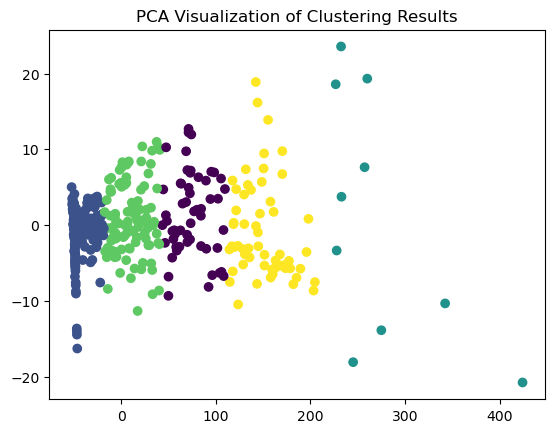

In [15]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming cluster_assignments is the array containing cluster assignments
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings)

plt.scatter(pca_result[:, 0], pca_result[:, 1], c=cluster_assignments, cmap='viridis')
plt.title('PCA Visualization of Clustering Results')
plt.show()

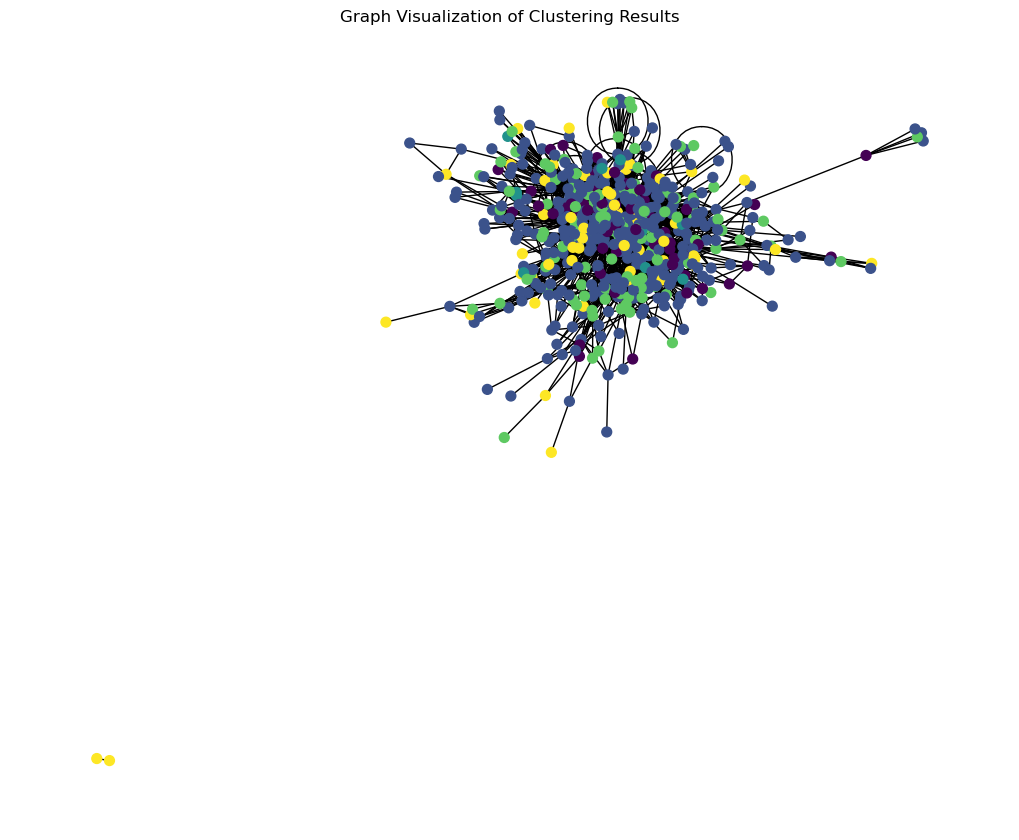

In [16]:
import networkx as nx

# Assuming data contains the graph structure
G = nx.Graph()
G.add_edges_from(data.edge_index.t().numpy())

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, node_color=cluster_assignments, cmap='viridis', with_labels=False, node_size=50)
plt.title('Graph Visualization of Clustering Results')
plt.show()

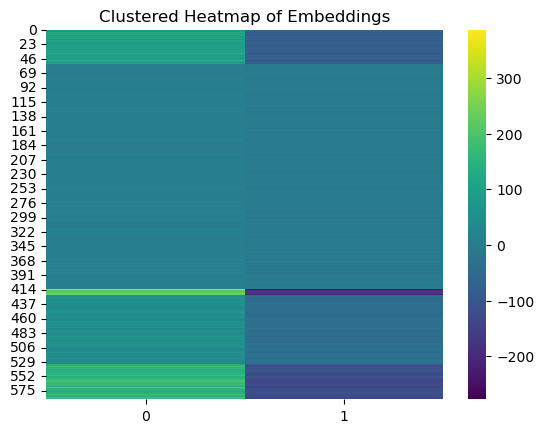

In [17]:
import seaborn as sns

# Assuming embeddings is a NumPy array containing embeddings
sns.heatmap(embeddings[cluster_assignments.argsort()], cmap='viridis')
plt.title('Clustered Heatmap of Embeddings')
plt.show()

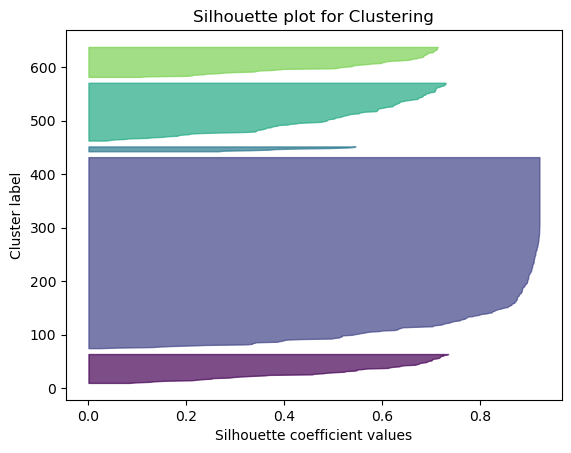

In [18]:
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np

# Assuming embeddings and cluster_assignments are available
silhouette_avg = silhouette_score(embeddings, cluster_assignments)
sample_silhouette_values = silhouette_samples(embeddings, cluster_assignments)

y_lower = 10
for i in range(num_clusters):
    cluster_i_values = sample_silhouette_values[cluster_assignments == i]
    cluster_i_values.sort()

    size_cluster_i = cluster_i_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.viridis(float(i) / num_clusters)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, cluster_i_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    y_lower = y_upper + 10

plt.title("Silhouette plot for Clustering")
plt.xlabel("Silhouette coefficient values")
plt.ylabel("Cluster label")
plt.show()

In [34]:
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering

# Perform clustering based on the learned embeddings
model.eval()
with torch.no_grad():
    embeddings = model(data.x, data.edge_index, data.edge_weight)

# Use PCA for dimensionality reduction
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings.cpu().numpy())

# Perform hierarchical clustering
num_clusters = 5
agg_cluster = AgglomerativeClustering(n_clusters=num_clusters, affinity='euclidean', linkage='ward')
cluster_assignments = agg_cluster.fit_predict(embeddings_pca)


/home/onuralpyigit/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


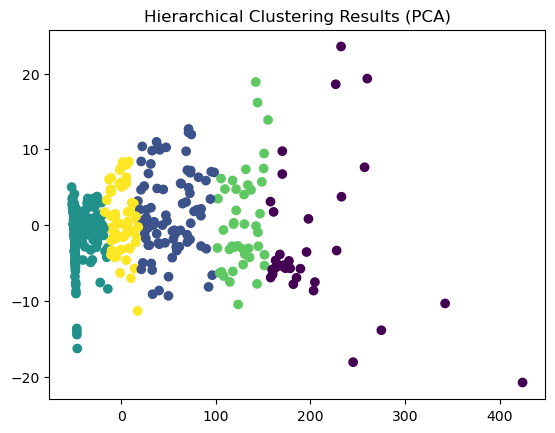

In [37]:
# Visualize clustering results using scatter plot
plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1],  c=cluster_assignments, cmap='viridis')
plt.title('Hierarchical Clustering Results (PCA)')
plt.show()

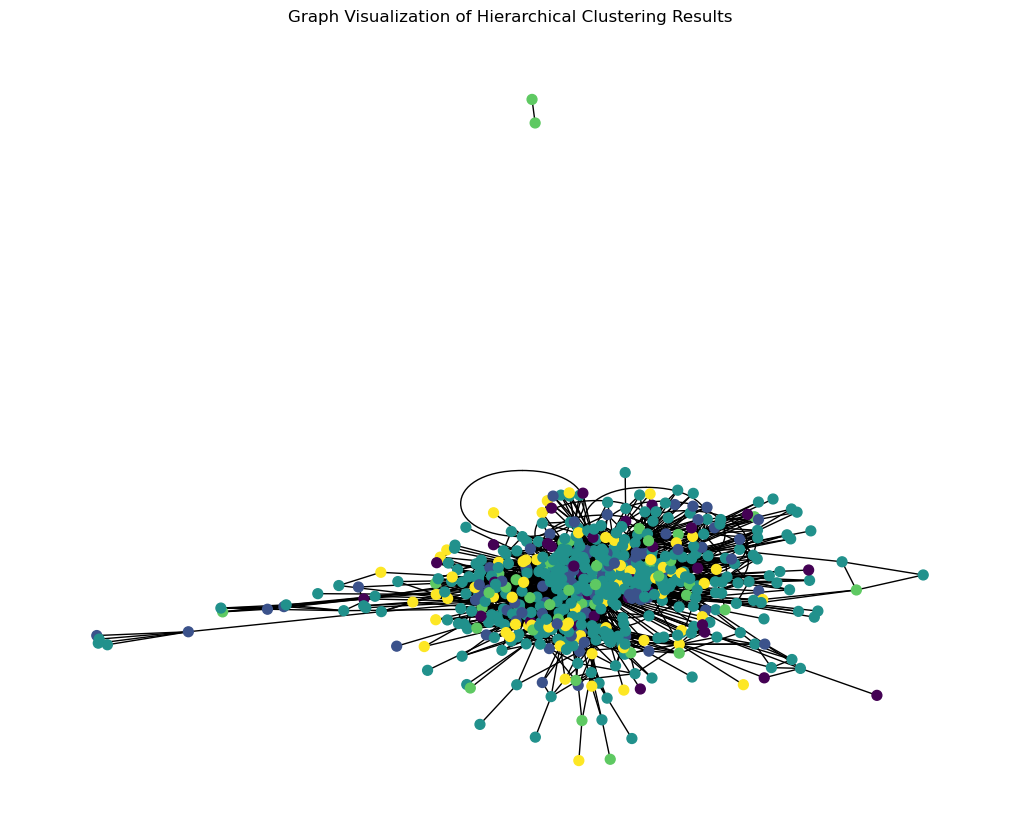

In [38]:
# Visualize clustering results using network visualization
G = nx.Graph()
G.add_edges_from(data.edge_index.t().numpy())

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, node_color=cluster_assignments, cmap='viridis', with_labels=False, node_size=50)
plt.title('Graph Visualization of Hierarchical Clustering Results')
plt.show()

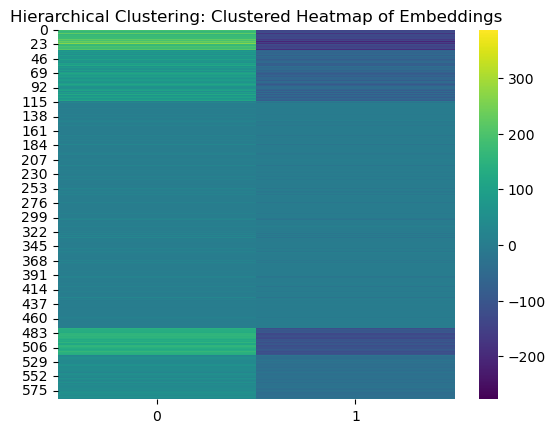

In [39]:
# Visualize clustering results using clustered heatmap
sns.heatmap(embeddings[cluster_assignments.argsort()], cmap='viridis')
plt.title('Hierarchical Clustering: Clustered Heatmap of Embeddings')
plt.show()

In [40]:
# Evaluate clustering performance (using Adjusted Rand Index)
ari = adjusted_rand_score(data.y.cpu().numpy(), cluster_assignments)
print(f'Adjusted Rand Index: {ari:.4f}')

Adjusted Rand Index: -0.0439
